# Time Series Recitation

In this lecture, we introduce tools to study time series data. 

Learning goals:
* Identify and remove trends and seasonal components from a time series
<!-- * Use external regressors -->
* Select a model, using AIC/BIC
* Fit ARIMA models to a time series
* Forecast using time series and form confidence intervals

Outline: 
0. Introducing the problems: 
1. Getting to Stationarity
  *   Removing trends 
  * Autocovariance + Partial Autocovariance Plots 
  *   Removing seasonal component
  * Information Criteria (AIC/BIC)
2. Example: Finding Trends in Climate Data
  * What is the extent of warming that can't be attributed to seasonal components or natural variability like El Niño Southern Oscillation?
  * Adding external regressors - how does this change our conclusion? 
  * Time of emergence
  * Explain why we stop where we do 
30. Motivate the problem! Main question, talk about the methods we use etc. 
3. Statistical Models
  * AR/MA Models
  * Sample Splitting for time series
  * Forecasting + confidence intervals
4. Example: Stock price forecasting 
  * Review steps for diagnosis 
  * How well can we predict stock prices using ARMA models?

## Getting to Stationarity 
In this section, we focus on a simulated time series with a quadratic trend and a sinusoidal component. 

As a refresher, we have two definitions of stationarity. 
Strong stationarity: the distribution is the same. 
Weak stationarity: the autocovariance is only a function of distance, and the mean is constant over time. 

In [1]:
# This code was used to generate the original dataset; 
import numpy as np
np.random.seed(1234)
x_vals = np.arange(0, 200)
quad_trend = x_vals ** 2 * 0.004 + 0.2 * x_vals
seasonality = 2 * (x_vals % 5 == 0) + 3 * (x_vals % 5 == 1) + 1 * (x_vals % 5 == 2) - 1 * (x_vals % 5 == 4)
random_noise = np.random.normal(size=len(x_vals))
y_vals = quad_trend + seasonality + random_noise

In [2]:
x = x_vals.reshape(-1,1)
y = y_vals.reshape(-1,1)

### Remove trends

We'll show two ways to remove trends - first differencing, and fitting and removing a line. 
To fit and remove the line, I recommend using a regression package such as `sklearn.linear_model.LinearRegression` ( look [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) for the user guide)


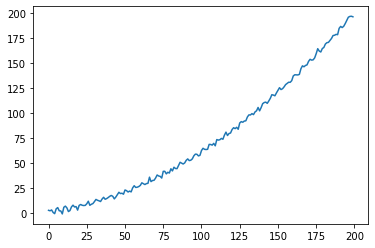

In [3]:
# No need to change this code
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# frame = pd.read_csv('https://raw.githubusercontent.com/maxoboe/6419_recitations/main/data/simulated.csv')
# x = frame['x'].values.reshape(-1,1)
# y = frame['y'].values.reshape(-1,1)
plt.plot(x, y)

[[0.99416153]]


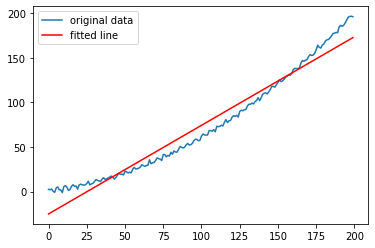

In [4]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(x, y)
print(clf.coef_) # Print the beta values found via regression 
y_hat = clf.predict(x)
plt.plot(x, y, label='original data')
plt.plot(x, y_hat, 'r', label='fitted line')
plt.legend()

Now, find and plot the residuals. Is there a clear pattern? 

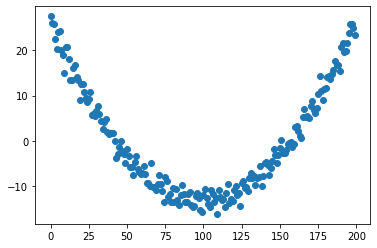

In [5]:
linear_residuals = y - y_hat
plt.plot(x, linear_residuals,'o')

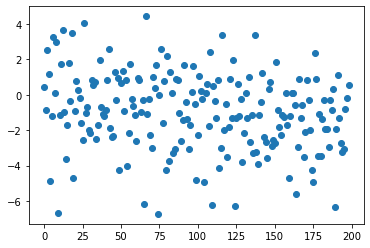

In [6]:
first_diff = y[:-1] - y[1:]
plt.plot(x[:-1],first_diff, 'o')


<AxesSubplot:>

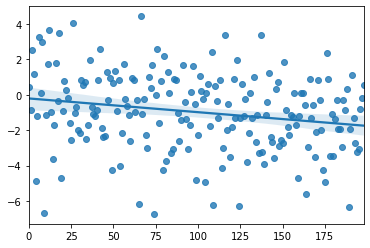

In [7]:
import seaborn as sns
sns.regplot(x=x[:-1], y=first_diff)

[[0.20268991 0.00397724]]


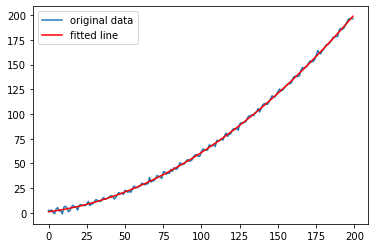

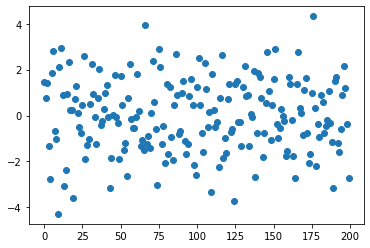

In [8]:
# Hint: to combine two numpy series, you can use the np.hstack command 
new_x = np.hstack((x, x**2))
clf.fit(new_x, y)
quadratic_y_hat = clf.predict(new_x)
print(clf.coef_) # Print the beta values found via regression 
plt.plot(x, y, label='original data')
plt.plot(x, quadratic_y_hat, 'r', label='fitted line')
plt.legend()
plt.show()
nonlinear_residuals = y - quadratic_y_hat
plt.plot(x, nonlinear_residuals,'o');

/Users/ifwonderland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

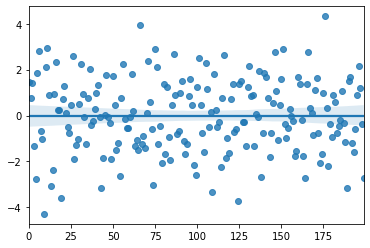

In [9]:
sns.regplot(x, nonlinear_residuals)

### ACF/PACF Plots
These plots are a useful tool for a many applications, including for identifying the existence of seasonal components in a dataset. 

I recommend using the time series analysis package from `statsmodels`, available [here](https://www.statsmodels.org/dev/_modules/statsmodels/graphics/tsaplots.html)

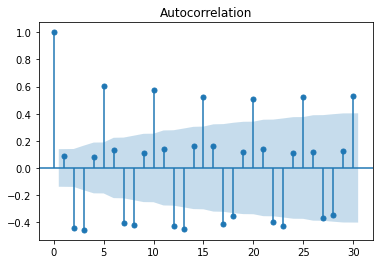

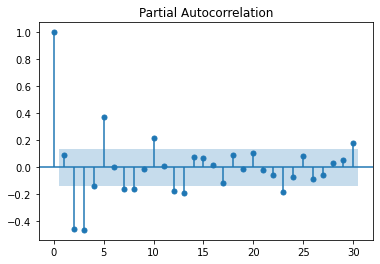

In [10]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(nonlinear_residuals, lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(nonlinear_residuals, lags=30)
plt.show()

### Removing Seasonal Component 
The first step is identifying the periodicity of the seasonal component, which we do by inspecting the time series and the ACF/PACF plots. 

After this stage, we present two methods to remove the seasonal component: by using a sinusoidal approximation to the seasonal component, and by fitting fixed-effects terms. 

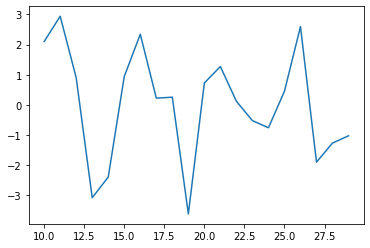

In [11]:
start_point = 10
num_points = 20
plt.plot(x[start_point:start_point + num_points],nonlinear_residuals[start_point:start_point + num_points])

Sinusoidal Approximation

Here, we use an optimization package to find the best sinusoidal approximation to this pattern. 

[1.72663296e+00 4.65270421e+00 2.15224310e-06]


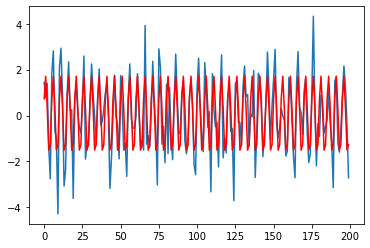

0.80773022531799


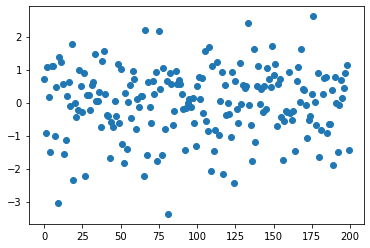

In [12]:
from scipy import optimize
freq = 5
def sine_function(X, amp, phase_shift, mean):
  return (amp * np.sin(1/freq * 2 * np.pi * (X - phase_shift)) + mean)
params, _ = sine_curve_fit = optimize.curve_fit(
  f = sine_function,
  xdata = x.flatten(),
  ydata = nonlinear_residuals.flatten(),
  p0 = np.array([3, 1, 10]))
print(params)
amp, phase_shift, mean = params
sin_approx = sine_function(x, amp, phase_shift, mean)
plt.plot(x, nonlinear_residuals, label='detrended data')
plt.plot(x, sin_approx, 'r', label='fitted line')
plt.plot()
plt.show()
sin_residuals = nonlinear_residuals - sin_approx
plt.plot(x, sin_residuals,'o');
print(np.mean(np.abs(sin_residuals)))

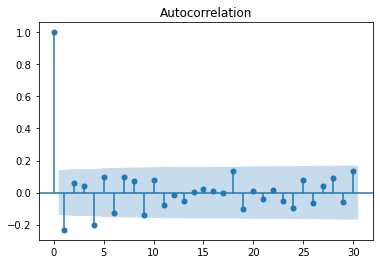

In [13]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(sin_residuals, lags=30)
plt.show()

Another approach: time-series fixed effects

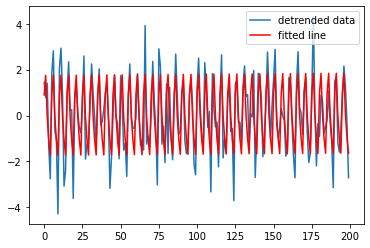

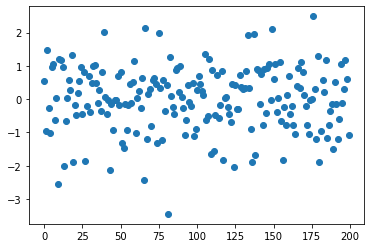

In [14]:
period = 5
x_with_fixed_effects = x
for i in range(period):
  x_with_fixed_effects = np.hstack((x_with_fixed_effects, (x % period)==i))
clf.fit(x_with_fixed_effects, nonlinear_residuals)
fixed_effects_predicted = clf.predict(x_with_fixed_effects)
plt.plot(x, nonlinear_residuals, label='detrended data')
plt.plot(x, fixed_effects_predicted, 'r', label='fitted line')
plt.legend();
plt.plot()
plt.show()
fixed_effects_residuals = nonlinear_residuals - fixed_effects_predicted
plt.plot(x, fixed_effects_residuals, 'o')

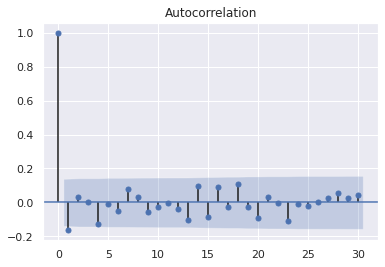

In [ ]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(fixed_effects_residuals, lags=30)
plt.show()

### Information Criteria
To select which model to use, comparing mean squared error is a good starting place, but it's better to have some other metrics. 
Information criteria are one such metric, that tell you about the balance between gaining more accuracy from including more terms and potentially overfitting the model. 
Models are selected to minimize AIC/BIC. 

In [ ]:
# Example here about how to find; what my assumption is behind this 
from scipy.stats import norm 
def evaluate_AIC(k, residuals):
  """
  Finds the AIC given the number of parameters estimated and 
  the residuals of the model. Assumes residuals are distributed 
  Gaussian with unknown variance. 
  """
  standard_deviation = np.std(residuals)
  log_likelihood = norm.logpdf(residuals, 0, scale=standard_deviation)
  return 2 * k - 2 * np.sum(log_likelihood)
def evaluate_BIC(k, residuals):
  """
  Finds the AIC given the number of parameters estimated and 
  the residuals of the model. Assumes residuals are distributed 
  Gaussian with unknown variance. 
  """
  standard_deviation = np.std(residuals)
  log_likelihood = norm.logpdf(residuals, 0, scale=standard_deviation)
  return k * np.log(len(residuals)) - 2 * np.sum(log_likelihood)

### Use Statsmodels to Detrend
For comparison, use Statsmodels package to remove
these same terms. See how this handles these packages. 

<ipython-input-15-15f0f78e3dad>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  res = seasonal_decompose(y, freq=5)


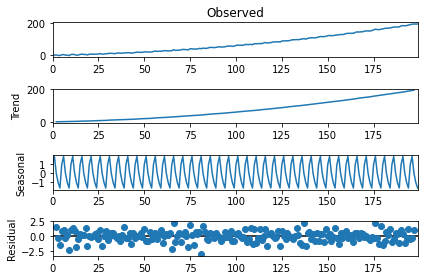

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(y, freq=5)
statsmodels_residuals = res.resid
res.plot()
plt.show()

In [ ]:
# plt.plot(x, detrended, label='detrended data')
for residual, label in zip([linear_residuals, nonlinear_residuals, sin_residuals, fixed_effects_residuals], 
                         ['linear', 'nonlinear', 'sinusoidal', 'fixed effects']):
  print('Mean squared error with {} method is: {}'.format(label, np.nanmean((residual)**2)))
for residual, label, DOF_used in zip([linear_residuals, nonlinear_residuals, sin_residuals, fixed_effects_residuals], 
                         ['linear', 'nonlinear', 'sinusoidal', 'fixed effects'], 
                         [1, 2, 5, 7]):
  print('AIC with {} method is: {}'.format(label, evaluate_AIC(DOF_used, residual)))
  print('BIC with {} method is: {}'.format(label, evaluate_BIC(DOF_used, residual)))

Mean squared error with linear method is: 143.13711757112156
Mean squared error with nonlinear method is: 2.546050085274335
Mean squared error with sinusoidal method is: 1.0553666355268405
Mean squared error with fixed effects method is: 0.9378462223736697
AIC with linear method is: 1562.3360202772824
BIC with linear method is: 1565.6343376438303
AIC with nonlinear method is: 758.4840476986762
BIC with nonlinear method is: 765.0806824317723
AIC with sinusoidal method is: 588.3530589584082
BIC with sinusoidal method is: 604.8446457911483
AIC with fixed effects method is: 568.7415561922267
BIC with fixed effects method is: 591.829777758063


## Example: Finding Trends in Climate Data

In this example, we examine whether climate data exhibits a trend. 
This question amounts to asking whether the climate has changed in the past 50 years. 

This question is actually pretty relevant to the discussion on climate change - there are many factors that make it challenging to observe a signal of anthropogenic climate change amid the noise of natural weather variability. 
The task of determining whether a weather phenomenon is related to climate change or natural variability is an ongoing field of research in environmental science. 
This example is closely related to the "time of emergence" literature, about when the signal of climate change is visible among the natural variability. 
For academic research, see [this source](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2012GL053952) and articles that cite it. 

How we're going to proceed in this class, is we're going to introduce some data, then we're going to try to find and remove any seasonal component, then we're going to look at some transformations of the data, then we're going to look at the remaining terms and see if there's a trend. 

### Datasets: Temperature Records and El Nino Index 

Temperature records are from World Bank. I'm looking at Boston temperatures, but I encourage you to look at your own city or region of interest. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


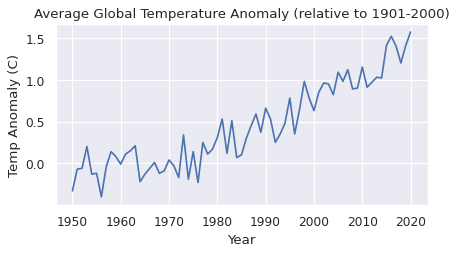

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


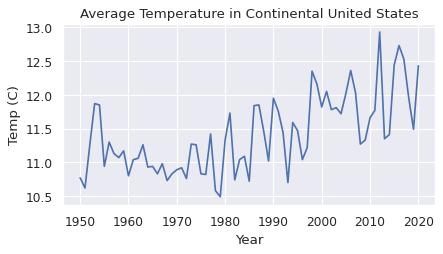

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


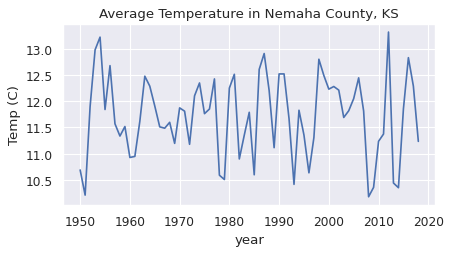

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


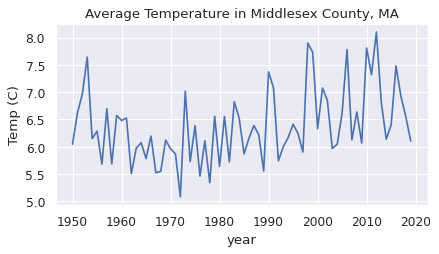

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set_theme()


plt.figure(figsize=(6, 3), dpi=80)
global_df = pd.read_csv('https://raw.githubusercontent.com/maxoboe/6419_recitations/main/data/global_temp.csv',skiprows=5)
sns.lineplot(global_df.Year, global_df.Value)
plt.title('Average Global Temperature Anomaly (relative to 1901-2000)')
plt.ylabel('Temp Anomaly (C)')
plt.show()
plt.figure(figsize=(6, 3), dpi=80)
US_df = pd.read_csv('https://raw.githubusercontent.com/maxoboe/6419_recitations/main/data/us_average_temp.csv',skiprows=5)
sns.lineplot(US_df.Date, US_df.Value)
plt.title('Average Temperature in Continental United States')
plt.ylabel('Temp (C)')
plt.xlabel('Year')
plt.show()

plt.figure(figsize=(6, 3), dpi=80)
climate_df = pd.read_csv('https://raw.githubusercontent.com/maxoboe/6419_recitations/main/data/annual_weather.csv')
subset = climate_df[climate_df.fips == 20131]
sns.lineplot(subset.year, subset.tAvg)
plt.title("Average Temperature in Nemaha County, KS")
plt.ylabel('Temp (C)')
plt.show()

plt.figure(figsize=(6, 3), dpi=80)
subset = climate_df[climate_df.fips == 23017] # Only looking at Boston
year = subset.year.values.reshape(-1,1)
temp = subset.tAvg.values.reshape(-1,1)
sns.lineplot(subset.year, subset.tAvg)
plt.title("Average Temperature in Middlesex County, MA")
plt.ylabel('Temp (C)')
plt.show()
# sns.regplot(climate_df.year, climate_df.tAvg, ci=None)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


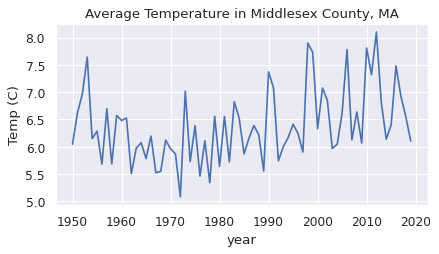

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set_theme()

plt.figure(figsize=(6, 3), dpi=80)
climate_df = pd.read_csv('https://raw.githubusercontent.com/maxoboe/6419_recitations/main/data/annual_weather.csv')
subset = climate_df[climate_df.fips == 23017] # Only looking at Boston
year = subset.year.values.reshape(-1,1)
temp = subset.tAvg.values.reshape(-1,1)
sns.lineplot(subset.year, subset.tAvg)
plt.title("Average Temperature in Middlesex County, MA")
plt.ylabel('Temp (C)')
plt.show()

In [ ]:
subset.head()

,Unnamed: 0,fips,year,prec,tAvg,tMax,tMin
1127,1127,23017,1950.0,0.261201,6.045459,12.384527,-0.293610
4164,4164,23017,1951.0,0.351008,6.617509,12.763306,0.471712
7201,7201,23017,1952.0,0.289846,6.964517,13.280014,0.649021
10238,10238,23017,1953.0,0.329602,7.642367,14.120450,1.164284
13275,13275,23017,1954.0,0.430148,6.147974,12.007143,0.288804


In [ ]:
US_df.head()

,Date,Value,Unnamed: 2
0,1950,10.77,NaN
1,1951,10.62,NaN
2,1952,11.26,NaN
3,1953,11.87,NaN
4,1954,11.85,NaN


El Nino index is from [here](https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php); we use ONI, which is a measure of how anomalously warm or cool the central-to-eastern equatorial Pacific Ocean is compared to "normal".

I've aggregated this data to yearly values to standardize the comparison; this index is only available from 1950-2020 so we focus on that range while incorporating this regressor. 

Text(0, 0.5, 'ONI')

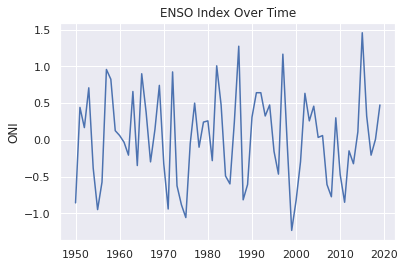

In [ ]:
# No need to change this block; reads data from github
import pandas as pd
enso_df = pd.read_csv('https://raw.githubusercontent.com/maxoboe/6419_recitations/main/data/enso_index.csv')
ONI = enso_df[enso_df.year.isin(climate_df.year)]['ONI_index'].values.reshape(-1,1)
plt.plot(year, ONI)
plt.title("ENSO Index Over Time")
plt.ylabel("ONI")

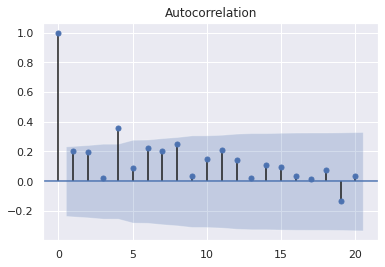

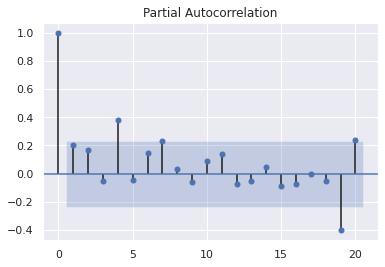

In [ ]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(temp, lags=20)
plt.show()
sm.graphics.tsa.plot_pacf(temp, lags=20)
plt.show()


### Removing seasonal component 

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


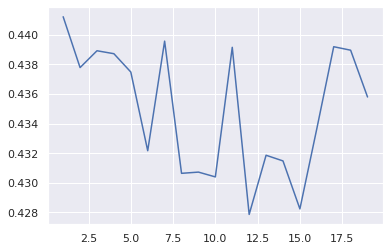

minimizing period is: 12


In [ ]:
from scipy import optimize
period_range = np.arange(1, 20)
mse_list = []

def find_sine_approximation(period, x_data=year, y_data=temp):
  """
  Finds a best-fitting sinusoidal approximation, for the given frequency. 
  """
  def sine_function(X, amp, phase_shift, mean):
    return (amp * np.sin(1/period * 2 * np.pi * (X - phase_shift)) + mean)
  params, _ = sine_curve_fit = optimize.curve_fit(
    f = sine_function,
    xdata = x_data.flatten(),
    ydata = y_data.flatten(),
    p0 = np.array([3, 1, 0]))
  amp, phase_shift, mean = params
  sin_prediction = sine_function(x_data, amp, phase_shift, mean)
  return sin_prediction
for period in period_range:
  sin_prediction = find_sine_approximation(period, year, temp)
  mse = np.nanmean((temp - sin_prediction) **2)
  mse_list.append(mse)
plt.plot(period_range, mse_list);
plt.show()
period_guess = period_range[np.argmin(mse_list)]
print("minimizing period is:", period_guess)

### Accounting for External Regressor 

[[-0.12268598]]


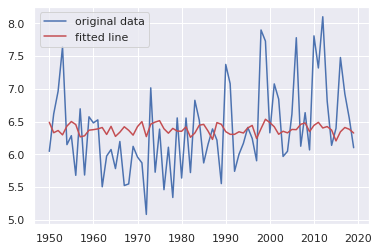

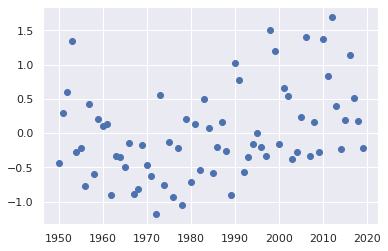

MSE with ENSO: 0.43556877235900093
AIC with ENSO: 142.47421409818256
BIC with ENSO: 144.72270934023192


In [ ]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(ONI, temp)
print(clf.coef_)
enso_predictions = clf.predict(ONI)
plt.plot(year, temp, label='original data')
plt.plot(year, enso_predictions, 'r', label='fitted line')
plt.legend()
plt.show()
enso_residuals = temp - enso_predictions
plt.plot(year, enso_residuals, 'o')
plt.show()
print("MSE with ENSO:", np.mean((enso_residuals)**2))
print("AIC with ENSO:", evaluate_AIC(1, enso_residuals))
print("BIC with ENSO:", evaluate_BIC(1, enso_residuals))

### What's left of the trend? 

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


12


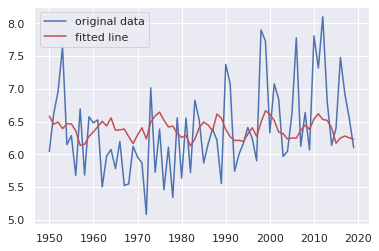

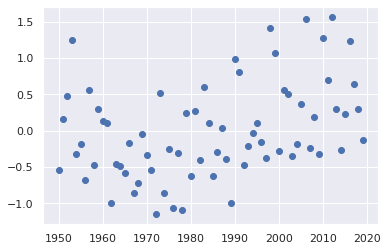

MSE with ENSO and sinusoid: 0.42628143542250224
AIC with ENSO and sinusoid: 148.96550934681946
BIC with ENSO and sinusoid: 160.20798555706625


In [ ]:
for period in period_range:
  sin_prediction = find_sine_approximation(period, year, enso_residuals)
  mse = np.nanmean((temp - sin_prediction) **2)
  mse_list.append(mse)
enso_period_guess = period_range[np.argmin(mse_list)]
print(enso_period_guess)
enso_sin_residuals = enso_residuals - find_sine_approximation(enso_period_guess, year, enso_residuals)
plt.plot(year, temp, label='original data')
plt.plot(year, temp - enso_sin_residuals, 'r', label='fitted line')
plt.legend()
plt.show()
plt.plot(year, enso_sin_residuals, 'o')
plt.show()
print("MSE with ENSO and sinusoid:", np.mean(enso_sin_residuals**2))
print("AIC with ENSO and sinusoid:", evaluate_AIC(5, enso_sin_residuals))
print("BIC with ENSO and sinusoid:", evaluate_BIC(5, enso_sin_residuals))

[[0.01139904]]


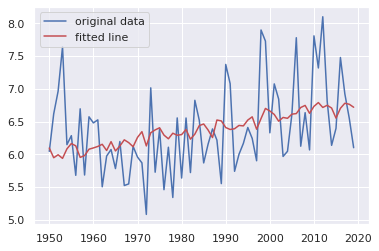

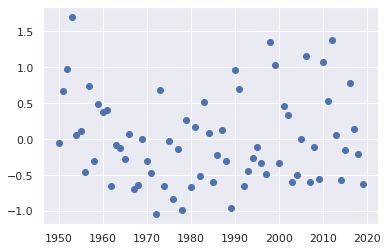

MSE with linear fit and accounting for ENSO: 0.38252152808629214
AIC with ENSO: 135.38347051819747
BIC with ENSO: 139.8804610022962


In [ ]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(year, enso_residuals)
print(clf.coef_) # To print the coefficient estimate of the series. 
linear_prediction = clf.predict(year)
linear_residuals = enso_residuals - linear_prediction
plt.plot(year, temp, label='original data')
plt.plot(year, temp - linear_residuals, 'r', label='fitted line')
plt.legend()
plt.show()
plt.plot(year, linear_residuals, 'o')
plt.show();
print("MSE with linear fit and accounting for ENSO:", np.mean(linear_residuals**2))
print("AIC with ENSO:", evaluate_AIC(2, linear_residuals))
print("BIC with ENSO:", evaluate_BIC(2, linear_residuals))

[[0.01144365]]


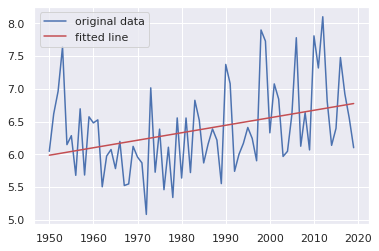

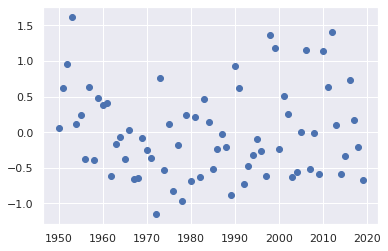

MSE with linear fit and accounting for ENSO: 0.38775595635948806
AIC with ENSO: 134.33485654939355
BIC with ENSO: 136.5833517914429


In [ ]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(year, temp)
print(clf.coef_) # To print the coefficient estimate of the series. 
linear_prediction = clf.predict(year)
linear_residuals = temp - linear_prediction
plt.plot(year, temp, label='original data')
plt.plot(year, temp - linear_residuals, 'r', label='fitted line')
plt.legend()
plt.show()
plt.plot(year, linear_residuals, 'o')
plt.show();
print("MSE with linear fit and accounting for ENSO:", np.mean(linear_residuals**2))
print("AIC with ENSO:", evaluate_AIC(1, linear_residuals))
print("BIC with ENSO:", evaluate_BIC(1, linear_residuals))

In [ ]:
sm.OLS(temp, year).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              6767.
Date:                Thu, 21 Apr 2022   Prob (F-statistic):                    1.32e-70
Time:                        22:27:14   Log-Likelihood:                         -68.577
No. Observations:                  70   AIC:                                      139.2
Df Residuals:                      69   BIC:                                      141.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0032   3.91e-05     82.265      0.000       0.003       0.003
==============================================================================
Omnibus:                        5.464   Durbin-Watson:                   1.686
Prob(Omnibus):                  0.065   Jarque-Bera (JB):                5.288
Skew:                           0.673   Prob(JB):                       0.0711
Kurtosis:                       2.938   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[[ 0.01137425 -0.11169069  0.97659784]]


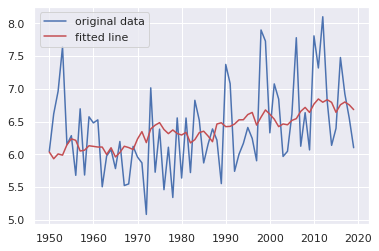

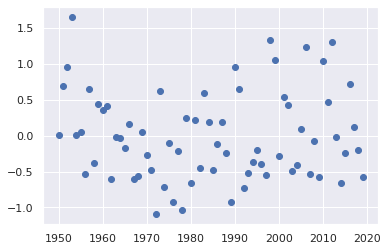

MSE with linear fit and accounting for ENSO and sinusoidal pattern: 0.378070458598611
AIC with linear, ENSO, sinusoid: 140.56416548600563
BIC with linear, ENSO, sinusoid: 151.80664169625243


In [ ]:
new_x = np.hstack((year, ONI, sin_prediction))
clf.fit(new_x, temp)
print(clf.coef_) # To print the coefficient estimate of the series. 
linear_prediction = clf.predict(new_x)
plt.plot(year, temp, label='original data')
plt.plot(year, linear_prediction, 'r', label='fitted line')
plt.legend()
plt.show()
linear_residuals = temp - linear_prediction
plt.plot(year, linear_residuals, 'o')
plt.show();
print("MSE with linear fit and accounting for ENSO and sinusoidal pattern:", np.mean((linear_residuals)**2))
print("AIC with linear, ENSO, sinusoid:", evaluate_AIC(5, linear_residuals))
print("BIC with linear, ENSO, sinusoid:", evaluate_BIC(5, linear_residuals))

### Conclusions: 
Looks like there is a trend. How do we formally test whether this trend exists? We use hypothesis testing on this $\beta$ term. 

Note that here, we might expect residuals to be correlated, so the standard assumptions about the covariance matrix don't quite apply. For this reason, we use robust standard errors. 

In [ ]:
TODO: fill in this section

## Statistical Models
Here, we mostly mean AR/MA models, but also we introduce some formal stuff about this. 
How do we measure these things? 
How do we assess the viability? 

One of the main questions for a time series model is prediction - what will happen after the sample? 
This section focuses on how we make such predictions, and express our uncertainty about those predictions. 

### ARIMA Models 
The general statistical model is ARIMA, or this general linear model. 
Here, we show how to use this package to implement the ARIMA model. 

### Simulate Dataset
First, we simulate a dataset with random noise and AR/MA terms. 

Note that not all AR processes are stationary; to generate stationary AR processes, I use the condition that the characteristic polynomial must have roots outside the unit circle.

For an order-$p$ time series $X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} \dots + \phi_p X_{t - p}$, there is a **characteristic polynomial** $\Phi(X_t) := 1 - \sum_{i=1}^p \phi_i X_{t-i}$. 
Note that we can equivalently express this polynomial as $\Phi(X_t) = \prod_{i=1}^p (1 - \alpha_i L) X_t$ where $L$ is the lag operator (i.e. $L(X_t) = X_{t-1}$.
By fixing all $\alpha_i = R$, for some constant $R \in (-1,1)$, we guarantee the time series is stationary. 

See [this link](https://math.unm.edu/~ghuerta/tseries/week4_1.pdf) for more details. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
import statsmodels.api as sm
def sim_dataset(AR, MA, t=100, trend = None, polynomial_root = -0.5, MA_weight = 0.5):
  """
  Simulates a dataset given AR or MA order. 
  Selects AR terms so that the polynomial root is the given value;
  as long as the root is within (-1, 1), the series will be stationary. 
  """
  if trend is None: 
    trend = lambda x: 0
  white_noise = np.random.normal(size=t + AR + MA)
  y = []
  for j in range(t + AR + MA):
    if AR > 0:
      ar_term = np.sum([-y[j - i] * comb(AR, i)*(polynomial_root)**(i) for i in range(1, AR + 1) if (j - i) >= 0])
    else:
      ar_term = 0
    if MA > 0:
      ma_term = MA_weight * np.mean([white_noise[j - i] for i in range(1, MA + 1) if (j - i) >= 0])
      if np.isnan(ma_term): ma_term = 0
    else:
      ma_term = 0
    value = white_noise[j] + ma_term + ar_term + trend(j)
    y.append(value)
  return np.array(y[AR + MA:])

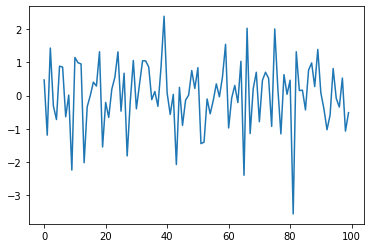

In [ ]:
np.random.seed(1234)
white_noise = sim_dataset(0, 0, 100)
plt.plot(white_noise)

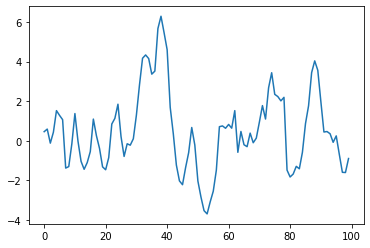

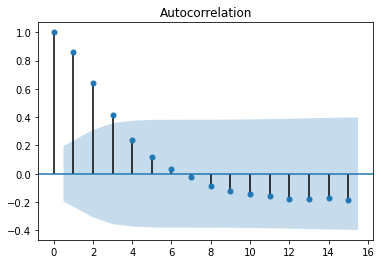

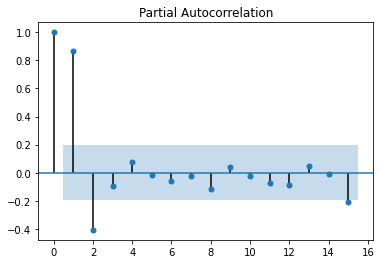

In [ ]:
np.random.seed(1234)
AR_series = sim_dataset(2, 0, 100, polynomial_root = -0.7)
plt.plot(AR_series)
plt.show()
sm.graphics.tsa.plot_acf(AR_series, lags=15)
plt.show()
sm.graphics.tsa.plot_pacf(AR_series, lags=15)
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


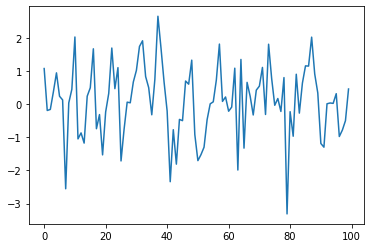

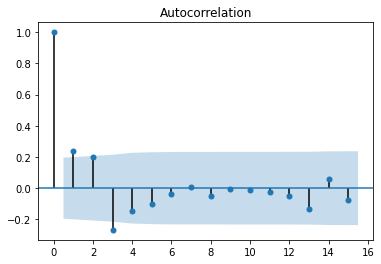

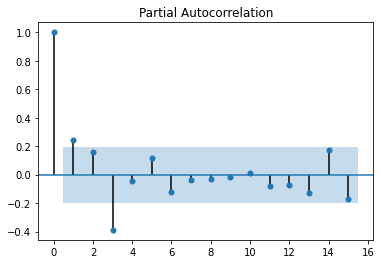

In [ ]:
np.random.seed(1234)
MA_series = sim_dataset(0, 2, 100, MA_weight=1)
plt.plot(MA_series)
plt.show()
sm.graphics.tsa.plot_acf(MA_series, lags=15)
plt.show()
sm.graphics.tsa.plot_pacf(MA_series, lags=15)
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


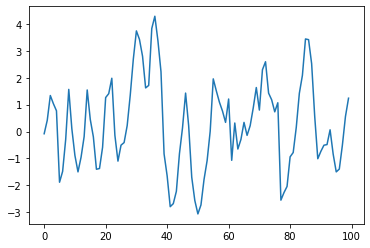

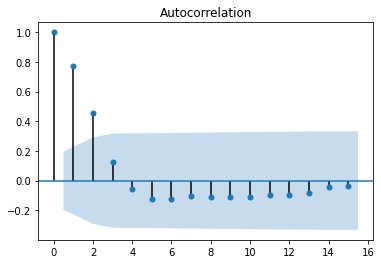

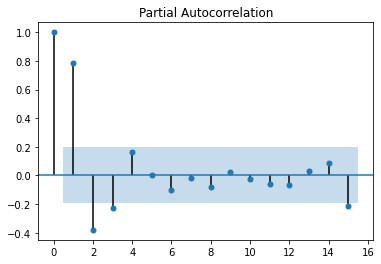

In [ ]:
np.random.seed(1234)
ARMA_series = sim_dataset(2, 2, 100, polynomial_root = -0.5)
plt.plot(ARMA_series)
plt.show()
sm.graphics.tsa.plot_acf(ARMA_series, lags=15)
plt.show()
sm.graphics.tsa.plot_pacf(ARMA_series, lags=15)
plt.show()

### Fitting ARIMA Models
Here, we use the SARIMAX package to fit models to the data

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -137.354
Date:                Wed, 02 Mar 2022   AIC                            280.708
Time:                        13:49:56   BIC                            288.524
Sample:                             0   HQIC                           283.871
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1791      0.100     11.768      0.000       0.983       1.375
ar.L2         -0.3614      0.100     -3.603      0.000      -0.558      -0.165
sigma2         0.8981      0.104      8.618      0.0

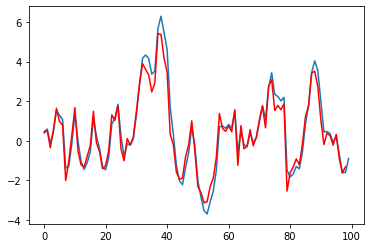

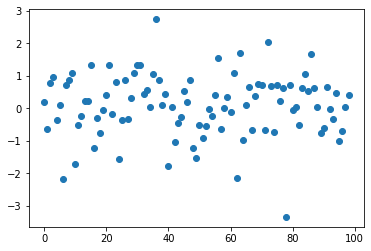

MSE with AR(1) model: 0.9067695900477506
AIC with AR(1) model: 276.4620019194502
BIC with AR(1) model: 284.24736146985396


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
AR_order = 2
ar_higher = SARIMAX(AR_series, order=(AR_order, 0, 0)).fit()
print(ar_higher.summary())
ar_higher_predictions = ar_higher.predict()
ar_higher_residuals = AR_series - ar_higher_predictions
ar_higher_residuals = ar_higher_residuals[1:] # Fitting AR 1 model means removing one observation
plt.plot(AR_series, label='original data')
plt.plot(ar_higher_predictions[1:], 'r', label='fitted line')
plt.show()
plt.plot(ar_higher_residuals, 'o')
plt.show()
print("MSE with AR(1) model:", np.mean(ar_higher_residuals**2))
print("AIC with AR(1) model:", evaluate_AIC(AR_order + 1, ar_higher_residuals))
print("BIC with AR(1) model:", evaluate_BIC(AR_order + 1, ar_higher_residuals))

In [ ]:
def grid_search_ARIMA(data, AR_range, MA_range, verbose=False):
  min_aic = np.inf 
  min_bic = np.inf
  min_aic_index = None
  min_bic_index = None 
  aic_matrix = np.zeros((len(AR_range), len(MA_range)))
  bic_matrix = np.zeros((len(AR_range), len(MA_range)))
  for AR_order in AR_range:
    for MA_order in MA_range:
      arma = SARIMAX(data, order=(AR_order, 0, MA_order)).fit()
      aic_matrix[AR_order, MA_order] = arma.aic
      bic_matrix[AR_order, MA_order] = arma.bic
      if arma.aic < min_aic:
        min_aic = arma.aic
        min_aic_index = (AR_order, 0, MA_order)
      if arma.bic < min_bic:
        min_bic = arma.bic
        min_bic_index = (AR_order, 0, MA_order)
  if verbose:
    print("Minimizing AIC order: ", min_aic_index)
    print("Minimizing BIC order: ", min_bic_index )
    print("matrix of AIC", aic_matrix)
    print("Matrix of BIC", bic_matrix)
  return min_aic_index, min_bic_index, aic_matrix, bic_matrix


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Minimizing AIC order:  (2, 0, 0)
Minimizing BIC order:  (2, 0, 0)
matrix of AIC [[430.97505899 348.30941446 307.47054703 292.90829332]
 [292.87651246 284.51688946 281.96758963 283.62242822]
 [280.70824443 282.17255313 283.48038877 284.91376109]
 [281.96142932 283.65984061 285.47703409 287.46207453]]
Matrix of BIC [[433.58022917 353.51975483 315.28605759 303.32897406]
 [298.08685283 292.33240002 292.38827038 296.64827915]
 [288.52375499 292.59323387 296.5062397  300.5447822 ]
 [292.38211007 296.68569154 301.10805521 305.69826583]]
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -137.354
Date:                Wed, 02 Mar 2022   AIC                            280.708
Time:                        14:39:15   BIC                            288.524
Sample:                             0   HQIC                         

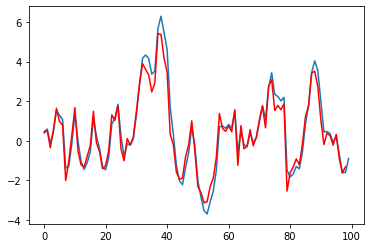

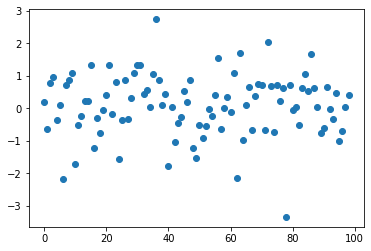

MSE with selected model: 0.9067695900477506


In [ ]:
min_aic_index, min_bic_index, _, _ = grid_search_ARIMA(AR_series, range(4), range(4), verbose=True)
if min_aic_index == min_bic_index:
  arma = SARIMAX(AR_series, order=min_bic_index).fit()
  print(arma.summary())
  arma_predictions = arma.predict()
  arma_residuals = AR_series - arma_predictions
  arma_residuals = arma_residuals[1:] # Fitting AR 1 model means removing one observation
  plt.plot(AR_series, label='original data')
  plt.plot(arma_predictions[1:], 'r', label='fitted line')
  plt.show()
  plt.plot(arma_residuals, 'o')
  plt.show()
  print("MSE with selected model:", np.mean(arma_residuals**2))
else:
  print("AIC, BIC do not agree.")

In [ ]:
min_aic_index, min_bic_index, _, _ = grid_search_ARIMA(MA_series, range(4), range(4), verbose=True)
if min_aic_index == min_bic_index:
  arma = SARIMAX(MA_series, order=min_bic_index).fit()
  print(arma.summary())
  arma_predictions = arma.predict()
  arma_residuals = MA_series - arma_predictions
  arma_residuals = arma_residuals[1:] # Fitting AR 1 model means removing one observation
  plt.plot(MA_series, label='original data')
  plt.plot(arma_predictions[1:], 'r', label='fitted line')
  plt.show()
  plt.plot(arma_residuals, 'o')
  plt.show()
  print("MSE with selected model:", np.mean(arma_residuals**2))
else:
  print("AIC, BIC do not agree.")

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Minimizing AIC order:  (0, 0, 3)
Minimizing BIC order:  (0, 0, 2)
matrix of AIC [[301.18194019 298.9582136  284.80574708 283.33198922]
 [296.99279112 298.39553047 284.24219389 283.54895882]
 [296.58492502 293.45615653 285.93528663 285.01393481]
 [283.68086654 285.60682205 285.91072621 286.93725014]]
Matrix of BIC [[303.78711038 304.16855397 292.62125764 293.75266996]
 [302.20313149 306.21104102 294.66287463 296.57480975]
 [304.40043558 303.87683727 298.96113756 300.64495592]
 [294.10154729 298.63267298 301.54174733 305.17344144]]
AIC, BIC do not agree.


Minimizing AIC order:  (1, 0, 2)
Minimizing BIC order:  (1, 0, 2)
matrix of AIC [[389.38969692 326.86871354 290.47463916 284.28005938]
 [297.7714876  291.71801412 282.15240001 283.81507032]
 [285.72045607 285.21318913 282.72892926 284.55447851]
 [282.87392054 283.30401394 284.33691716 286.3304048 ]]
Matrix of BIC [[391.9948671  332.07905391 298.29014972 294.70074013]
 [302.98182797 299.53352468 292.57308076 296.84092125]
 [293.53596663 295.63386988 295.75478019 300.18549963]
 [293.29460129 296.32986487 299.96793828 304.5665961 ]]
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -137.076
Date:                Wed, 02 Mar 2022   AIC                            282.152
Time:                        14:39:18   BIC                            292.573
Sample:                             0   HQIC                         

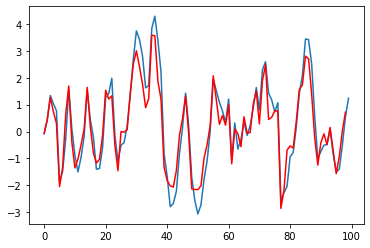

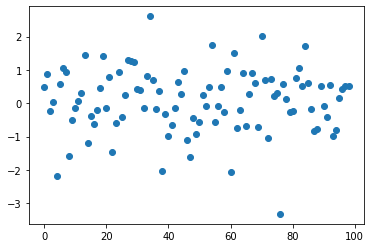

MSE with selected model: 0.9056026386354776


In [ ]:
min_aic_index, min_bic_index, _, _ = grid_search_ARIMA(ARMA_series, range(4), range(4), verbose=True)
if min_aic_index == min_bic_index:
  arma = SARIMAX(ARMA_series, order=min_bic_index).fit()
  print(arma.summary())
  arma_predictions = arma.predict()
  arma_residuals = ARMA_series - arma_predictions
  arma_residuals = arma_residuals[1:] # Fitting AR 1 model means removing one observation
  plt.plot(ARMA_series, label='original data')
  plt.plot(arma_predictions[1:], 'r', label='fitted line')
  plt.show()
  plt.plot(arma_residuals, 'o')
  plt.show()
  print("MSE with selected model:", np.mean(arma_residuals**2))
else:
  print("AIC, BIC do not agree.")

### Adding ARMA Model to Climate 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


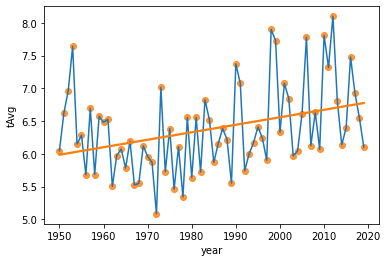

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
climate_df = pd.read_csv('https://raw.githubusercontent.com/maxoboe/6419_recitations/main/data/annual_weather.csv')
climate_df = climate_df[climate_df.fips == 23017] # Only looking at Boston
year = climate_df.year.values.reshape(-1,1)
temp = climate_df.tAvg.values.reshape(-1,1)
sns.lineplot(climate_df.year, climate_df.tAvg)
sns.regplot(climate_df.year, climate_df.tAvg, ci=None)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


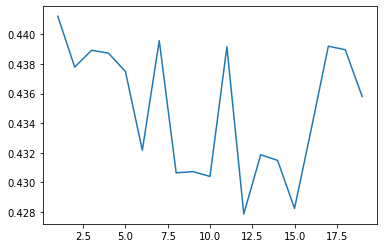

In [ ]:
enso_df = pd.read_csv('https://raw.githubusercontent.com/maxoboe/6419_recitations/main/data/enso_index.csv')
ONI = enso_df[enso_df.year.isin(climate_df.year)]['ONI_index'].values.reshape(-1,1)
period_range = np.arange(1, 20)
mse_list = []

def find_sine_approximation(period, x_data=year, y_data=temp):
  """
  Finds a best-fitting sinusoidal approximation, for the given frequency. 
  """
  def sine_function(X, amp, phase_shift, mean):
    return (amp * np.sin(1/period * 2 * np.pi * (X - phase_shift)) + mean)
  params, _ = sine_curve_fit = optimize.curve_fit(
    f = sine_function,
    xdata = x_data.flatten(),
    ydata = y_data.flatten(),
    p0 = np.array([3, 1, 0]))
  amp, phase_shift, mean = params
  sin_prediction = sine_function(x_data, amp, phase_shift, mean)
  return sin_prediction
for period in period_range:
  sin_prediction = find_sine_approximation(period, year, temp)
  mse = np.nanmean((temp - sin_prediction) **2)
  mse_list.append(mse)
plt.plot(period_range, mse_list);
plt.show()
period_guess = period_range[np.argmin(mse_list)]
sin_prediction = find_sine_approximation(period_guess, year, temp)

In [ ]:
trend_options = [None, 'ct']
trend_labels = ['none','constant + linear']
exog_options = [None, ONI, sin_prediction, np.hstack([ONI, sin_prediction])]
exog_labels = ['none','ENSO', 'sin','ENSO + sin']
def grid_search_ARIMA_trend(data, AR_range, MA_range, 
                            trend_options, trend_labels, exog_options, exog_labels, verbose=False):
  min_aic = np.inf 
  min_bic = np.inf
  min_aic_index = None
  min_bic_index = None 
  aic_dict = {}
  bic_dict = {}
  aic_label = None
  bic_label = None
  for AR_order in AR_range:
    for MA_order in MA_range:
      for trend, trend_label in zip(trend_options, trend_labels):
        for exog, exog_label in zip(exog_options, exog_labels):
          arma = SARIMAX(data, exog=exog, trend = trend, order=(AR_order, 0, MA_order)).fit()
          aic_dict[AR_order, MA_order, trend_label, exog_label] = arma.aic
          bic_dict[AR_order, MA_order, trend_label, exog_label] = arma.bic
          if arma.aic < min_aic:
            min_aic = arma.aic
            min_aic_index = (AR_order, 0, MA_order), trend, exog 
            aic_label = (AR_order, MA_order, trend_label, exog_label)
          if arma.bic < min_bic:
            min_bic = arma.bic
            min_bic_index = (AR_order, 0, MA_order), trend, exog 
            bic_label = (AR_order, MA_order, trend_label, exog_label)
  if verbose:
    print("Minimizing AIC order: ", aic_label)
    print("Minimizing BIC order: ", bic_label )
    # print("matrix of AIC", aic_matrix)
    # print("Matrix of BIC", bic_matrix)
  return min_aic_index, min_bic_index, aic_dict, bic_dict
min_aic_index, min_bic_index, _, _ = grid_search_ARIMA_trend(temp, range(3), range(3), 
                        trend_options, trend_labels, exog_options, exog_labels, verbose=True)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

Minimizing AIC order:  (0, 0, 'constant + linear', 'sin')
Minimizing BIC order:  (0, 0, 'constant + linear', 'none')


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:

arma = SARIMAX(temp, order=min_aic_index[0], trend=min_aic_index[1], exog = min_aic_index[2]).fit()
print(arma.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   70
Model:                        SARIMAX   Log Likelihood                 -64.249
Date:                Wed, 02 Mar 2022   AIC                            136.498
Time:                        16:16:23   BIC                            145.492
Sample:                             0   HQIC                           140.071
                                 - 70                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9637      4.231     -0.464      0.643     -10.257       6.329
drift          0.0123      0.004      3.476      0.001       0.005       0.019
x1             1.2413      0.657      1.888      0.0

In [ ]:
from io import StringIO
sum_table = pd.read_csv(StringIO(arma.summary().tables[1].as_csv()), index_col=0)
sum_table = sum_table.rename(mapper=lambda x: x.strip() if isinstance(x, str) else x)
sum_table = sum_table.transpose()
sum_table = sum_table.rename(mapper=lambda x: x.strip() if isinstance(x, str) else x)
if 'drift' in sum_table:
  print("Model selects drift of ", sum_table['drift']['coef'], " with p value ", sum_table['drift']['P>|z|'])
else:
  print("Model does not select drift")

Model selects drift of  0.0123  with p value  0.001


In [ ]:
list(sum_table)

['intercept', 'drift', 'x1', 'ma.L1', 'sigma2']

### Sample Splitting
Want to talk about why we do sample splitting this way. The goal is to mimic the setting that we're interested in. 
Can't really do cross-folds, but can do repeated tests as we increase the sample size, which is somewhat similar. 

In this case, if we want to predict values into the future, let's look at like 3 steps ahead or whatever. 

In [ ]:
# We'll be evaluating how well various models forecast - to do so, we split the data
# into train/test sets using the first 80% of the observations as training data
train_test_split = int(len(price) * 0.8)
train_price, test_price = stationary_price[:train_test_split], stationary_price[train_test_split:]
train_date, test_date = date[:train_test_split], date[train_test_split:]
assert(len(train_date) + len(test_date) == len(date))

### Confidence Intervals
To generate confidence intervals for forecasts, we need to consider variability both from the data and from our estimates of parameters of the statistical model. 
Luckily, some very generous person has already implemented such a model, so we're just using their work. 

In [ ]:
arma = SARIMAX(month_train, order=min_bic_index).fit()
fig, ax = plt.subplots(figsize=(15, 5))

# Construct the forecasts
fcast = arma.get_forecast(len(month_test)).summary_frame()

arma_predictions = arma.predict()
ax.plot(month_date, month_quad_residuals, label='original data')
predicted_values = arma_predictions[1:].reshape(-1,1)
ax.plot(month_date_train[1:], predicted_values, 'r', label='fitted line')
forecast_means = fcast['mean'].values.reshape(-1,1)
ax.plot(month_date_test, forecast_means, 'k--', label='mean forecast')
ax.fill_between(month_date_test.flatten(), fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
plt.legend();

## Example: Forecasting Stock Price
In this example, we apply these tools to forecast several days of a stock price. 
We consider seasonal effects, ARIMA models, and (lagged) versions of external regressors to form predictions, then we use this to forecast the stock price. 


In [ ]:
!pip install statsmodels --upgrade
!pip install yfinance

     |████████████████████████████████| 9.8 MB 22.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 6.4 MB 42.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


All available NASDAQ listings: 
   Symbol  ... Round Lot Size
0   AAIT  ...          100.0
1    AAL  ...          100.0
2   AAME  ...          100.0
3   AAOI  ...          100.0
4   AAON  ...          100.0

[5 rows x 7 columns]
Sample of FB stock series: 
                  Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2012-05-18  42.049999  45.000000  38.000000  38.230000  38.230000  573576400
2012-05-21  36.529999  36.660000  33.000000  34.029999  34.029999  168192700
2012-05-22  32.610001  33.590000  30.940001  31.000000  31.000000  101786600
2012-05-23  31.370001  32.500000  31.360001  32.000000  32.000000   73600000
2012-05-24  32.950001  33.209999  31.770000  33.029999  33.029999   50237200


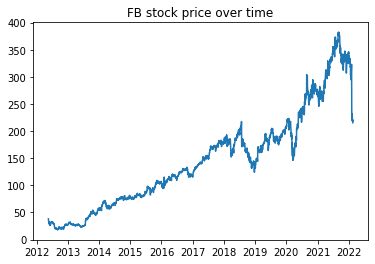

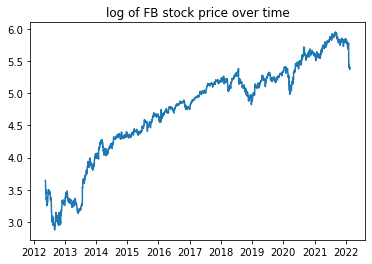

In [ ]:
"""
No need to change this block - loads dataset and necessary packages
"""
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import io
import yfinance as yf
url="https://pkgstore.datahub.io/core/nasdaq-listings/nasdaq-listed_csv/data/7665719fb51081ba0bd834fde71ce822/nasdaq-listed_csv.csv"
s = requests.get(url).content
companies = pd.read_csv(io.StringIO(s.decode('utf-8')))
print("All available NASDAQ listings: \n", companies.head())
msft = yf.download("FB",start='2009-06-01',progress=False)
print("Sample of FB stock series: \n", msft.head())
price = msft.reset_index()['Close'].values.reshape(-1,1)
date = msft.reset_index().Date.dt.date.values.reshape(-1,1)
plt.plot(date, price)
plt.title("FB stock price over time")
plt.show()
log_price = np.log(price)
plt.plot(date, log_price)
plt.title("log of FB stock price over time")
plt.show()

[[ 1.89326084e-03 -3.55848542e-07]]


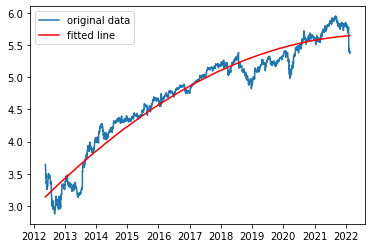

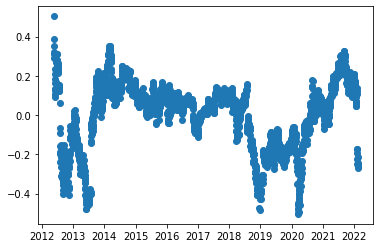

MSE with linear fit: 0.02923386940198311


In [ ]:
## After linear fit, it seems like a higher order model is needed
clf = linear_model.LinearRegression()
index = msft.reset_index().index.values.reshape(-1,1)

new_x = np.hstack((index, index **2))
clf.fit(new_x, log_price)
print(clf.coef_) # To print the coefficient estimate of the series. 
quad_prediction = clf.predict(new_x)
plt.plot(date, log_price, label='original data')
plt.plot(date, quad_prediction, 'r', label='fitted line')
plt.legend()
plt.show()
quad_residuals = log_price - quad_prediction
plt.plot(date, quad_residuals, 'o')
plt.show();
print("MSE with linear fit:", np.mean((quad_residuals)**2))

In [ ]:
model.conf_int()